In [3]:
import numpy as np
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import time

In [4]:
class GridWorld:
    def __init__(self, size=100, obstacle_chance=0.3):
        self.size = size
        self.grid = np.zeros((size, size))
        self.initialize_grid(obstacle_chance)
        
    def initialize_grid(self, obstacle_chance):
        # Place obstacles randomly in the grid
        for x in range(self.size):
            for y in range(self.size):
                if random.random() < obstacle_chance:
                    self.grid[x][y] = 1  # Mark as obstacle
        
        # Define random start and end points
        while True:
            self.start = (random.randint(0, self.size - 1), random.randint(0, self.size - 1))
            self.goal = (random.randint(0, self.size - 1), random.randint(0, self.size - 1))
            
            # Ensure both points are empty and different from each other
            if self.grid[self.start] == 0 and self.grid[self.goal] == 0 and self.start != self.goal:
                break

        # Create a basic path between start and goal
        self.clear_path()
    
    def clear_path(self):
        # Clear a basic path from start to goal for better exploration
        x1, y1 = self.start
        x2, y2 = self.goal
        
        for x in range(min(x1, x2), max(x1, x2) + 1):
            self.grid[x][y1] = 0
        for y in range(min(y1, y2), max(y1, y2) + 1):
            self.grid[x2][y] = 0
    
    def get_possible_actions(self, state):
        x, y = state
        actions = []
        # Check the 4 possible moves: right, down, left, up
        for dx, dy in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < self.size and 0 <= ny < self.size and self.grid[nx][ny] == 0:
                actions.append((dx, dy))
        return actions
    
    def step(self, state, action):
        x, y = state
        dx, dy = action
        next_state = (x + dx, y + dy)
        
        if next_state == self.goal:
            return next_state, 100, True  # Reached goal with reward
        elif not (0 <= next_state[0] < self.size and 0 <= next_state[1] < self.size) or self.grid[next_state] == 1:
            return state, -100, False  # Hit obstacle or wall, penalize
        
        return next_state, -1, False  # Regular step with small penalty


In [5]:
class ValueIteration:
    def __init__(self, env, discount=0.99):
        self.env = env
        self.discount = discount
        self.values = defaultdict(float)
        self.policy = {}
    
    def compute_policy(self, max_iters=1000, min_diff=1e-3):
        for _ in range(max_iters):
            diff = 0
            for i in range(self.env.size):
                for j in range(self.env.size):
                    if self.env.grid[i][j] == 1:
                        continue
                    
                    state = (i, j)
                    if state == self.env.goal:
                        continue
                        
                    old_value = self.values[state]
                    actions = self.env.get_possible_actions(state)
                    action_values = [self.env.step(state, action)[1] + self.discount * self.values[self.env.step(state, action)[0]] for action in actions]
                    
                    if action_values:
                        self.values[state] = max(action_values)
                        diff = max(diff, abs(old_value - self.values[state]))
            
            if diff < min_diff:
                break
        
        # Update policy based on computed values
        for i in range(self.env.size):
            for j in range(self.env.size):
                state = (i, j)
                if self.env.grid[i][j] == 1 or state == self.env.goal:
                    continue
                
                actions = self.env.get_possible_actions(state)
                if actions:
                    best_action = max(actions, key=lambda a: self.env.step(state, a)[1] + self.discount * self.values[self.env.step(state, a)[0]])
                    self.policy[state] = best_action

In [6]:
class QLearning:
    def __init__(self, env, alpha=0.1, discount=0.99, exploration=0.1):
        self.env = env
        self.alpha = alpha
        self.discount = discount
        self.exploration = exploration
        self.q_table = defaultdict(lambda: defaultdict(float))
        
    def select_action(self, state):
        if random.random() < self.exploration:
            return random.choice(self.env.get_possible_actions(state))
        
        return max(self.env.get_possible_actions(state), key=lambda a: self.q_table[state][a])
    
    def train(self, episodes=10000):
        for _ in range(episodes):
            state = self.env.start
            done = False
            
            while not done:
                action = self.select_action(state)
                next_state, reward, done = self.env.step(state, action)
                
                best_next_value = max([self.q_table[next_state][a] for a in self.env.get_possible_actions(next_state)], default=0)
                self.q_table[state][action] += self.alpha * (reward + self.discount * best_next_value - self.q_table[state][action])
                
                state = next_state
    
    def get_policy(self):
        policy = {}
        for i in range(self.env.size):
            for j in range(self.env.size):
                state = (i, j)
                if self.env.grid[i][j] == 1 or state == self.env.goal:
                    continue
                
                actions = self.env.get_possible_actions(state)
                if actions:
                    policy[state] = max(actions, key=lambda a: self.q_table[state][a])
        return policy

In [7]:
def run_benchmark(size=100, obstacle_chance=0.3):
    env = GridWorld(size=size, obstacle_chance=obstacle_chance)
    
    # Value Iteration
    start_time = time.time()
    vi = ValueIteration(env)
    vi.compute_policy()
    vi_time = time.time() - start_time
    
    # Q-Learning
    start_time = time.time()
    ql = QLearning(env)
    ql.train()
    ql_time = time.time() - start_time
    
    return {
        'env': env,
        'value_iteration': {
            'time': vi_time,
            'policy': vi.policy
        },
        'q_learning': {
            'time': ql_time,
            'policy': ql.get_policy()
        }
    }

In [8]:
def display_path(env, policy, title):
    if not policy:
        return
    
    grid = env.grid.copy()
    current = env.start
    path = [current]
    
    while current != env.goal and len(path) < env.size * env.size:
        if current not in policy:
            break
        action = policy[current]
        current = (current[0] + action[0], current[1] + action[1])
        path.append(current)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(grid, cmap='binary')
    path = np.array(path)
    plt.plot(path[:, 1], path[:, 0], 'r-', linewidth=2, label='Path')
    plt.plot(env.start[1], env.start[0], 'go', label='Start')
    plt.plot(env.goal[1], env.goal[0], 'ro', label='Goal')
    plt.title(title)
    plt.legend()
    plt.show()

Value Iteration Time: 15.67 seconds
Q-Learning Time: 43.46 seconds


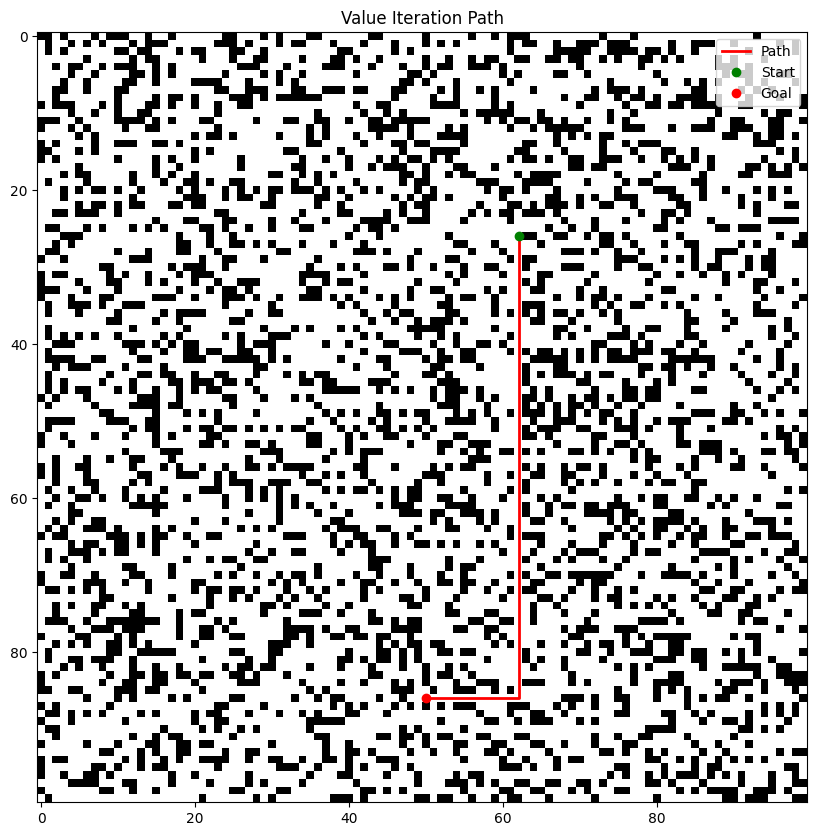

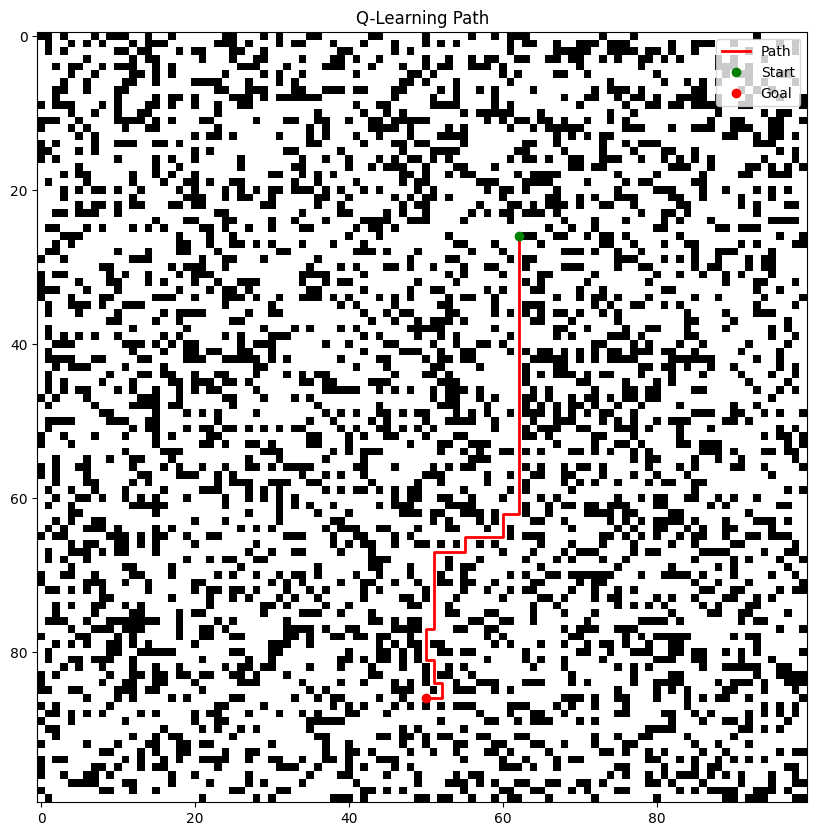

In [11]:
# Execute benchmark
results = run_benchmark()

# Show results
print(f"Value Iteration Time: {results['value_iteration']['time']:.2f} seconds")
print(f"Q-Learning Time: {results['q_learning']['time']:.2f} seconds")

display_path(results['env'], results['value_iteration']['policy'], 'Value Iteration Path')
display_path(results['env'], results['q_learning']['policy'], 'Q-Learning Path')
